In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
housing

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'frame': None,
 'target_names': ['MedHouseVal'],
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n

In [5]:
df = pd.DataFrame(housing['data'], columns=housing['feature_names'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [6]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df, housing['target'],
                                                    test_size=0.2, random_state=42)

In [7]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=500)
model.fit(train_x, train_y)

RandomForestRegressor(n_estimators=500)

In [8]:
model.score(train_x, train_y), model.score(test_x, test_y)

(0.9743737934110901, 0.8075312458561839)

In [9]:
from sklearn.model_selection import KFold
import xgboost as xgb
import optuna

In [12]:
def objective(trial):
    params = {
        # 損失関数は2乗誤差
        'objective': 'reg:squarederror',
        # logスケールで10^-8～1の一様分布
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        # 1～9の整数で一様分布
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        # 0～1の一様分布
        'gamma': trial.suggest_uniform('gamma', 0, 1),
        # 0～1の一様分布
        'subsample': trial.suggest_uniform('subsample', 0, 1),
        # 0～1の一様分布
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0, 1),
        # 10～1000の整数で一様分布
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000)
    }

    scores = []
    for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=42).split(df):
        x_train, x_test = df.values[train_index], df.values[test_index]
        y_train, y_test = housing['target'][train_index], housing['target'][test_index]

        model = xgb.XGBRegressor(**params)
        model.fit(x_train, y_train)
        scores += [model.score(x_test, y_test)]
    scores = np.array(scores)
    # スコアの負を返す（目的関数を最小化するため）
    return -scores.mean()

if __name__ == '__main__':

    study = optuna.create_study()
    study.optimize(objective, n_trials=100)

    print(study.best_params)
    print(study.best_value)
    print(study.best_trial)

[I 2021-07-27 01:53:08,637] A new study created in memory with name: no-name-852273dd-5fec-4c21-95b5-6920e30847e3
[I 2021-07-27 01:53:26,914] Trial 0 finished with value: -0.8169110165280861 and parameters: {'eta': 0.027551103490971583, 'max_depth': 7, 'gamma': 0.76546275975211, 'subsample': 0.6874838627062277, 'colsample_bylevel': 0.15290703731121014, 'n_estimators': 487}. Best is trial 0 with value: -0.8169110165280861.
[I 2021-07-27 01:54:10,370] Trial 1 finished with value: 1.847388846390467 and parameters: {'eta': 3.0367646475613494e-07, 'max_depth': 9, 'gamma': 0.4269519478986783, 'subsample': 0.9379459560075206, 'colsample_bylevel': 0.2655353696010091, 'n_estimators': 605}. Best is trial 0 with value: -0.8169110165280861.
[I 2021-07-27 01:54:20,573] Trial 2 finished with value: -0.8201837720880988 and parameters: {'eta': 0.03439661281293666, 'max_depth': 5, 'gamma': 0.15031263361285818, 'subsample': 0.6529624014765942, 'colsample_bylevel': 0.41708330074826616, 'n_estimators': 27

[I 2021-07-27 02:00:47,606] Trial 25 finished with value: -0.6138029701496703 and parameters: {'eta': 0.010587237291329722, 'max_depth': 9, 'gamma': 0.4389996556855891, 'subsample': 0.9631203399251871, 'colsample_bylevel': 0.039152786649597565, 'n_estimators': 157}. Best is trial 6 with value: -0.8438692461830748.
[I 2021-07-27 02:01:32,329] Trial 26 finished with value: -0.29487823600803614 and parameters: {'eta': 0.001211536333490795, 'max_depth': 8, 'gamma': 0.30020990373644985, 'subsample': 0.8324287928944932, 'colsample_bylevel': 0.3476042712853572, 'n_estimators': 755}. Best is trial 6 with value: -0.8438692461830748.
[I 2021-07-27 02:01:59,193] Trial 27 finished with value: -0.8177227198002444 and parameters: {'eta': 0.23300933512680647, 'max_depth': 8, 'gamma': 0.5366618082588861, 'subsample': 0.6441370887829841, 'colsample_bylevel': 0.058519565665659135, 'n_estimators': 598}. Best is trial 6 with value: -0.8438692461830748.
[I 2021-07-27 02:02:10,955] Trial 28 finished with va

[I 2021-07-27 02:13:50,500] Trial 51 finished with value: -0.8379960082330756 and parameters: {'eta': 0.12308212907343671, 'max_depth': 7, 'gamma': 0.6701575910371926, 'subsample': 0.3757201741256905, 'colsample_bylevel': 0.5530972617551209, 'n_estimators': 1000}. Best is trial 31 with value: -0.8469412052628588.
[I 2021-07-27 02:14:26,767] Trial 52 finished with value: -0.7817096640738916 and parameters: {'eta': 0.4261522782653247, 'max_depth': 6, 'gamma': 0.5687814181873001, 'subsample': 0.4472293034613867, 'colsample_bylevel': 0.4720070855056576, 'n_estimators': 985}. Best is trial 31 with value: -0.8469412052628588.
[I 2021-07-27 02:15:07,216] Trial 53 finished with value: -0.8446242109384947 and parameters: {'eta': 0.07260574183809197, 'max_depth': 7, 'gamma': 0.6551473317131118, 'subsample': 0.4117396770734222, 'colsample_bylevel': 0.8224318721083507, 'n_estimators': 919}. Best is trial 31 with value: -0.8469412052628588.
[I 2021-07-27 02:15:34,465] Trial 54 finished with value: 

[I 2021-07-27 02:31:40,646] Trial 77 finished with value: -0.6923097866312837 and parameters: {'eta': 0.6721687404008444, 'max_depth': 8, 'gamma': 0.24770562553481187, 'subsample': 0.5893878055290196, 'colsample_bylevel': 0.9914264767680417, 'n_estimators': 751}. Best is trial 74 with value: -0.8506477757140022.
[I 2021-07-27 02:32:15,406] Trial 78 finished with value: -0.8401507399237895 and parameters: {'eta': 0.014897209323211678, 'max_depth': 7, 'gamma': 0.3879983618957526, 'subsample': 0.7186405813171135, 'colsample_bylevel': 0.9565236374847385, 'n_estimators': 613}. Best is trial 74 with value: -0.8506477757140022.
[I 2021-07-27 02:32:55,593] Trial 79 finished with value: -0.8514218598562652 and parameters: {'eta': 0.05686235734304286, 'max_depth': 8, 'gamma': 0.12989814770841485, 'subsample': 0.637526326585875, 'colsample_bylevel': 0.8634962335696391, 'n_estimators': 650}. Best is trial 79 with value: -0.8514218598562652.
[I 2021-07-27 02:33:33,674] Trial 80 finished with value:

{'eta': 0.05686235734304286, 'max_depth': 8, 'gamma': 0.12989814770841485, 'subsample': 0.637526326585875, 'colsample_bylevel': 0.8634962335696391, 'n_estimators': 650}
-0.8514218598562652
FrozenTrial(number=79, values=[-0.8514218598562652], datetime_start=datetime.datetime(2021, 7, 27, 2, 32, 15, 407769), datetime_complete=datetime.datetime(2021, 7, 27, 2, 32, 55, 592589), params={'eta': 0.05686235734304286, 'max_depth': 8, 'gamma': 0.12989814770841485, 'subsample': 0.637526326585875, 'colsample_bylevel': 0.8634962335696391, 'n_estimators': 650}, distributions={'eta': LogUniformDistribution(high=1.0, low=1e-08), 'max_depth': IntUniformDistribution(high=9, low=1, step=1), 'gamma': UniformDistribution(high=1.0, low=0.0), 'subsample': UniformDistribution(high=1.0, low=0.0), 'colsample_bylevel': UniformDistribution(high=1.0, low=0.0), 'n_estimators': IntUniformDistribution(high=1000, low=10, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=79, state=TrialState.CO

In [13]:
def objective(trial):
    params = {
        # 損失関数は2乗誤差
        'objective': 'reg:squarederror',
        # logスケールで10^-8～1の一様分布
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        # 1～9の整数で一様分布
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        # 0～1の一様分布
        'gamma': trial.suggest_uniform('gamma', 0, 1),
        # 0～1の一様分布
        'subsample': trial.suggest_uniform('subsample', 0, 1),
        # 0～1の一様分布
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0, 1),
        # 10～1000の整数で一様分布
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000)
    }

    scores = []
    for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=42).split(df):
        x_train, x_test = df.values[train_index], df.values[test_index]
        y_train, y_test = housing['target'][train_index], housing['target'][test_index]

        model = xgb.XGBRegressor(**params)
        model.fit(x_train, y_train)
        scores += [model.score(x_test, y_test)]
    scores = np.array(scores)
    # スコアの負を返す（目的関数を最小化するため）
    return -scores.mean()

if __name__ == '__main__':

    study2 = optuna.create_study()
    study2.optimize(objective, n_trials=100)

    print(study2.best_params)
    print(study2.best_value)
    print(study2.best_trial)

[I 2021-07-27 02:45:39,031] A new study created in memory with name: no-name-c52a8f9e-96b7-4f2f-b176-00a540ad0137
[I 2021-07-27 02:45:59,479] Trial 0 finished with value: -0.6653023639212592 and parameters: {'eta': 0.007096828884059276, 'max_depth': 1, 'gamma': 0.5052991585791321, 'subsample': 0.12452332632105112, 'colsample_bylevel': 0.2870637974664868, 'n_estimators': 1941}. Best is trial 0 with value: -0.6653023639212592.
[I 2021-07-27 02:48:50,170] Trial 1 finished with value: -0.8479037476027459 and parameters: {'eta': 0.07094147174833376, 'max_depth': 7, 'gamma': 0.2536075947055695, 'subsample': 0.4516004245998301, 'colsample_bylevel': 0.588118043108562, 'n_estimators': 3951}. Best is trial 1 with value: -0.8479037476027459.
[I 2021-07-27 02:55:04,619] Trial 2 finished with value: 0.5860440505146226 and parameters: {'eta': 4.2853567395960576e-05, 'max_depth': 9, 'gamma': 0.38128212000429007, 'subsample': 0.20150987068483472, 'colsample_bylevel': 0.8883110777060154, 'n_estimators'

[I 2021-07-27 05:05:58,555] Trial 25 finished with value: -0.7725834879899738 and parameters: {'eta': 0.0002815211226304635, 'max_depth': 8, 'gamma': 0.7275413431571195, 'subsample': 0.8492987945286916, 'colsample_bylevel': 0.30869466956729086, 'n_estimators': 8968}. Best is trial 18 with value: -0.8562961078380413.
[I 2021-07-27 05:11:16,447] Trial 26 finished with value: -0.8530036453803855 and parameters: {'eta': 0.025392488460348923, 'max_depth': 5, 'gamma': 0.35174596771502603, 'subsample': 0.9554955267746544, 'colsample_bylevel': 0.9937698996987949, 'n_estimators': 7479}. Best is trial 18 with value: -0.8562961078380413.
[I 2021-07-27 05:17:41,314] Trial 27 finished with value: -0.6096860444135903 and parameters: {'eta': 0.9453689740306038, 'max_depth': 6, 'gamma': 0.5364384116626889, 'subsample': 0.6282789503650784, 'colsample_bylevel': 0.6312930297683392, 'n_estimators': 8987}. Best is trial 18 with value: -0.8562961078380413.
[I 2021-07-27 05:21:11,381] Trial 28 finished with 

[I 2021-07-27 07:37:22,974] Trial 50 finished with value: -0.0031529869168297033 and parameters: {'eta': 0.00010906579357857243, 'max_depth': 9, 'gamma': 0.1992934646964149, 'subsample': 0.2654778713422907, 'colsample_bylevel': 0.07554616048741228, 'n_estimators': 6597}. Best is trial 18 with value: -0.8562961078380413.
[I 2021-07-27 07:45:09,256] Trial 51 finished with value: -0.8571142320280106 and parameters: {'eta': 0.008378469945855749, 'max_depth': 8, 'gamma': 0.06292942357771605, 'subsample': 0.8685845482170546, 'colsample_bylevel': 0.264700678879411, 'n_estimators': 7561}. Best is trial 51 with value: -0.8571142320280106.
[I 2021-07-27 07:52:38,437] Trial 52 finished with value: -0.8575094590050814 and parameters: {'eta': 0.012425639966320417, 'max_depth': 8, 'gamma': 0.005400528875512005, 'subsample': 0.8681803551696091, 'colsample_bylevel': 0.2554398555534336, 'n_estimators': 7164}. Best is trial 52 with value: -0.8575094590050814.
[I 2021-07-27 07:59:00,962] Trial 53 finishe

[I 2021-07-27 10:32:38,375] Trial 75 finished with value: -0.8556896717458062 and parameters: {'eta': 0.06233792870939471, 'max_depth': 7, 'gamma': 0.031807944839288005, 'subsample': 0.914820837141262, 'colsample_bylevel': 0.6617903077980307, 'n_estimators': 4461}. Best is trial 61 with value: -0.8589105609504024.
[I 2021-07-27 10:38:26,648] Trial 76 finished with value: -0.844595062428915 and parameters: {'eta': 0.17199905107936264, 'max_depth': 8, 'gamma': 0.021180397319860312, 'subsample': 0.8831960189631077, 'colsample_bylevel': 0.5772000097848005, 'n_estimators': 5110}. Best is trial 61 with value: -0.8589105609504024.
[I 2021-07-27 10:42:19,501] Trial 77 finished with value: -0.8550550330013816 and parameters: {'eta': 0.04080472896831694, 'max_depth': 7, 'gamma': 0.0922617806271786, 'subsample': 0.9711173957621061, 'colsample_bylevel': 0.8363750863922834, 'n_estimators': 3795}. Best is trial 61 with value: -0.8589105609504024.
[I 2021-07-27 10:48:02,499] Trial 78 finished with va

{'eta': 0.006716840802880437, 'max_depth': 8, 'gamma': 0.060097452138558695, 'subsample': 0.8847218813487688, 'colsample_bylevel': 0.5771928190352562, 'n_estimators': 7210}
-0.8589105609504024
FrozenTrial(number=61, values=[-0.8589105609504024], datetime_start=datetime.datetime(2021, 7, 27, 8, 52, 14, 42863), datetime_complete=datetime.datetime(2021, 7, 27, 9, 0, 26, 665743), params={'eta': 0.006716840802880437, 'max_depth': 8, 'gamma': 0.060097452138558695, 'subsample': 0.8847218813487688, 'colsample_bylevel': 0.5771928190352562, 'n_estimators': 7210}, distributions={'eta': LogUniformDistribution(high=1.0, low=1e-08), 'max_depth': IntUniformDistribution(high=9, low=1, step=1), 'gamma': UniformDistribution(high=1.0, low=0.0), 'subsample': UniformDistribution(high=1.0, low=0.0), 'colsample_bylevel': UniformDistribution(high=1.0, low=0.0), 'n_estimators': IntUniformDistribution(high=10000, low=100, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=61, state=Trial

In [15]:
import pickle
with open('xgb_study1.bin', mode="wb") as f:
    pickle.dump(study, f)

In [16]:
with open('xgb_study2.bin', mode="wb") as f:
    pickle.dump(study2, f)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80
...,...,...,...,...,...,...,...,...
11284,6.3700,35.0,6.129032,0.926267,658.0,3.032258,33.78,-117.96
11964,3.0500,33.0,6.868597,1.269488,1753.0,3.904232,34.02,-117.43
5390,2.9344,36.0,3.986717,1.079696,1756.0,3.332068,34.03,-118.38
860,5.7192,15.0,6.395349,1.067979,1777.0,3.178891,37.58,-121.96


In [22]:
from sklearn.ensemble import RandomForestRegressor
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'criterion': ['mse', 'mae'][trial.suggest_int('critarion_index', 0, 1)],
        'max_features': trial.suggest_int('max_features', 1, 8),
        'max_depth': [None,1,2,3,4,5,6,7,8,9,10][trial.suggest_int('max_depth', 0, 10)],
        'n_jobs': -1
    }

    scores = []
    for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=42).split(df):
        x_train, x_test = df.values[train_index], df.values[test_index]
        y_train, y_test = housing['target'][train_index], housing['target'][test_index]

        model = RandomForestRegressor(**params)
        model.fit(x_train, y_train)
        scores += [model.score(x_test, y_test)]
    scores = np.array(scores)
    # スコアの負を返す（目的関数を最小化するため）
    return -scores.mean()

if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective_rf, n_trials=10)

    print(study.best_params)
    print(study.best_value)
    print(study.best_trial)

[I 2021-07-27 17:04:20,572] A new study created in memory with name: no-name-0f85a17c-9997-4866-a279-2555c711b1ee
[I 2021-07-27 17:04:21,066] Trial 0 finished with value: -0.6597391903369761 and parameters: {'n_estimators': 29, 'critarion_index': 0, 'max_features': 3, 'max_depth': 5}. Best is trial 0 with value: -0.6597391903369761.
[I 2021-07-27 17:07:56,757] Trial 1 finished with value: -0.8138012178052769 and parameters: {'n_estimators': 70, 'critarion_index': 1, 'max_features': 6, 'max_depth': 0}. Best is trial 1 with value: -0.8138012178052769.
[I 2021-07-27 17:08:32,707] Trial 2 finished with value: -0.784106291217016 and parameters: {'n_estimators': 35, 'critarion_index': 1, 'max_features': 1, 'max_depth': 0}. Best is trial 1 with value: -0.8138012178052769.
[I 2021-07-27 17:08:33,890] Trial 3 finished with value: -0.61614916359041 and parameters: {'n_estimators': 61, 'critarion_index': 0, 'max_features': 8, 'max_depth': 4}. Best is trial 1 with value: -0.8138012178052769.
[I 20

{'n_estimators': 70, 'critarion_index': 1, 'max_features': 6, 'max_depth': 0}
-0.8138012178052769
FrozenTrial(number=1, values=[-0.8138012178052769], datetime_start=datetime.datetime(2021, 7, 27, 17, 4, 21, 66302), datetime_complete=datetime.datetime(2021, 7, 27, 17, 7, 56, 757590), params={'n_estimators': 70, 'critarion_index': 1, 'max_features': 6, 'max_depth': 0}, distributions={'n_estimators': IntUniformDistribution(high=100, low=10, step=1), 'critarion_index': IntUniformDistribution(high=1, low=0, step=1), 'max_features': IntUniformDistribution(high=8, low=1, step=1), 'max_depth': IntUniformDistribution(high=10, low=0, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1, state=TrialState.COMPLETE, value=None)


In [27]:
import sys
scores = []
i=1
for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=42).split(df):
    print(f"{i}-th validation...", file=sys.stderr)
    i+=1
    x_train, x_test = df.values[train_index], df.values[test_index]
    y_train, y_test = housing['target'][train_index], housing['target'][test_index]

    model = RandomForestRegressor(n_estimators=500, criterion='mse', n_jobs=-1)
    model.fit(x_train, y_train)
    scores += [model.score(x_test, y_test)]
scores = np.array(scores)
print(f"{scores.mean():.4f}±{scores.std():.4f}")

1-th validation...
2-th validation...
3-th validation...
4-th validation...
5-th validation...


0.8122±0.0082


In [32]:
train_index.size

16512

In [35]:
scores = []
for rate in [min(0.001 * 2**i,1) for i in range(11)]:
    scores_ = []
    print(f"rate={rate}", file=sys.stderr)
    for i,(train_index, test_index) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(df)):
        x_train, x_test = df.values[train_index[:int(train_index.size*rate)]], df.values[test_index]
        y_train, y_test = housing['target'][train_index[:int(train_index.size*rate)]], housing['target'][test_index]

        model = RandomForestRegressor(n_estimators=500, criterion='mse', n_jobs=-1)
        model.fit(x_train, y_train)
        scores_ += [[model.score(x_train, y_train), model.score(x_test, y_test)]]
    scores += [scores_]
scores = np.array(scores)

rate=0.001
rate=0.002
rate=0.004
rate=0.008
rate=0.016
rate=0.032
rate=0.064
rate=0.128
rate=0.256
rate=0.512
rate=1


In [40]:
scores.mean(axis=1)[:, 0], scores.mean(axis=1)[:, 1]

(array([0.96286523, 0.97704359, 0.9618742 , 0.96669845, 0.96774032,
        0.97068454, 0.97380471, 0.97948206, 0.97991799, 0.97823648,
        0.97429717]),
 array([-0.08107788, -0.00142995, -0.50374898, -0.1255074 ,  0.33911903,
         0.26353648,  0.47207722, -0.01579959,  0.56173624,  0.7149651 ,
         0.81245026]))

In [45]:
df.index.size

20640

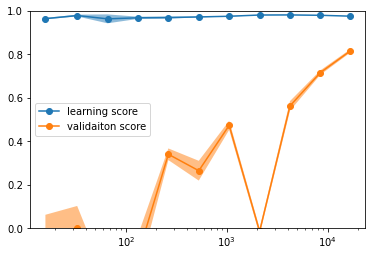

In [57]:
n_sample = [int(df.index.size*0.8*min(0.001 * 2**i,1)) for i in range(11)]
plt.plot(n_sample, scores.mean(axis=1)[:, 0], marker="o", label="learning score")
plt.fill_between(n_sample,
                 scores.mean(axis=1)[:, 0]-scores.std(axis=1)[:, 0],
                 scores.mean(axis=1)[:, 0]+scores.std(axis=1)[:, 0], alpha=0.5)
plt.plot(n_sample, scores.mean(axis=1)[:, 1], marker="o", label="validaiton score")
plt.fill_between(n_sample,
                 scores.mean(axis=1)[:, 1]-scores.std(axis=1)[:, 1],
                 scores.mean(axis=1)[:, 1]+scores.std(axis=1)[:, 1], alpha=0.5)
plt.xscale("log")
plt.ylim(0,1)
plt.legend()
plt.show()

In [59]:
np.save('RF_learning_curve.npy', scores)

In [58]:
n_samples = [int(df.index.size*0.8*min(0.001 * 1.4**i,1)) for i in range(22)]
n_samples

[16,
 23,
 32,
 45,
 63,
 88,
 124,
 174,
 243,
 341,
 477,
 668,
 936,
 1310,
 1834,
 2568,
 3596,
 5034,
 7048,
 9868,
 13815,
 16512]

In [60]:
n_samples = [int(df.index.size*0.8*min(0.001 * 1.4**i,1)) for i in range(22)]
scores = []

for n_sample in n_samples:
    scores_ = []
    print(f"n_sample={n_sample}", file=sys.stderr)
    for i,(train_index, test_index) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(df)):
        x_train, x_test = df.values[train_index[:n_sample]], df.values[test_index]
        y_train, y_test = housing['target'][train_index[:n_sample]], housing['target'][test_index]

        model = RandomForestRegressor(n_estimators=500, criterion='mse', n_jobs=-1)
        model.fit(x_train, y_train)
        scores_ += [[model.score(x_train, y_train), model.score(x_test, y_test)]]
    scores += [scores_]
scores = np.array(scores)

n_sample=16
n_sample=23
n_sample=32
n_sample=45
n_sample=63
n_sample=88
n_sample=124
n_sample=174
n_sample=243
n_sample=341
n_sample=477
n_sample=668
n_sample=936
n_sample=1310
n_sample=1834
n_sample=2568
n_sample=3596
n_sample=5034
n_sample=7048
n_sample=9868
n_sample=13815
n_sample=16512


In [187]:
[int(df.index.size*2/3*min(0.001 * 1.4**i,1)) for i in range(22)]

[13,
 19,
 26,
 37,
 52,
 74,
 103,
 145,
 203,
 284,
 398,
 557,
 780,
 1092,
 1529,
 2140,
 2996,
 4195,
 5873,
 8223,
 11512,
 13760]

In [62]:
np.save('RF_learning_curve_2.npy', scores)

In [76]:
scores = np.load('RF_learning_curve_2.npy')

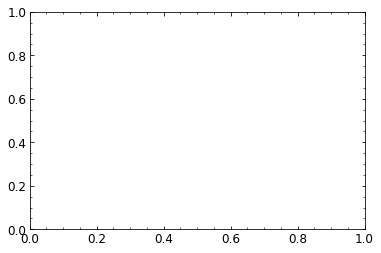

In [74]:
plt.rcParams['font.family'] ='sans-serif' #フォント選択
plt.rcParams['font.size'] = 12 #フォントの大きさ
plt.rcParams["xtick.minor.visible"] = True #補助目盛りの追加
plt.rcParams["ytick.minor.visible"] = True
plt.gca().xaxis.set_tick_params(which='both', direction='in',bottom=True, top=True)
plt.gca().yaxis.set_tick_params(which='both', direction='in',left=True, right=True)

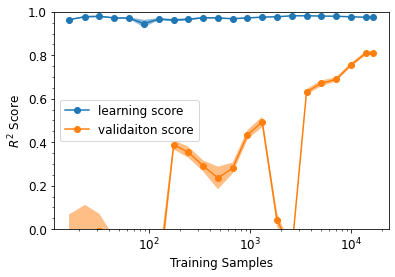

In [77]:
plt.plot(n_samples, scores.mean(axis=1)[:, 0], marker="o", label="learning score")
plt.fill_between(n_samples,
                 scores.mean(axis=1)[:, 0]-scores.std(axis=1)[:, 0],
                 scores.mean(axis=1)[:, 0]+scores.std(axis=1)[:, 0], alpha=0.5)
plt.plot(n_samples, scores.mean(axis=1)[:, 1], marker="o", label="validaiton score")
plt.fill_between(n_samples,
                 scores.mean(axis=1)[:, 1]-scores.std(axis=1)[:, 1],
                 scores.mean(axis=1)[:, 1]+scores.std(axis=1)[:, 1], alpha=0.5)
plt.xscale("log")
plt.ylim(0,1)
plt.xlabel("Training Samples")
plt.ylabel(r"$R^2$ Score")
plt.legend()
plt.show()

In [69]:
n_estimators_ = [10, 20, 30, 60, 100, 200, 300, 600, 1000]
scores = []

for n_estimators in n_estimators_:
    scores_ = []
    print(f"n_estimators={n_estimators}", file=sys.stderr)
    for i,(train_index, test_index) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(df)):
        x_train, x_test = df.values[train_index], df.values[test_index]
        y_train, y_test = housing['target'][train_index], housing['target'][test_index]

        model = RandomForestRegressor(n_estimators=n_estimators, criterion='mse', n_jobs=-1)
        model.fit(x_train, y_train)
        scores_ += [[model.score(x_train, y_train), model.score(x_test, y_test)]]
    scores += [scores_]
scores = np.array(scores)

n_estimators=10
n_estimators=20
n_estimators=30
n_estimators=60
n_estimators=100
n_estimators=200
n_estimators=300
n_estimators=600
n_estimators=1000


In [73]:
np.save('RF_validaiton_n_samples.npy', scores)

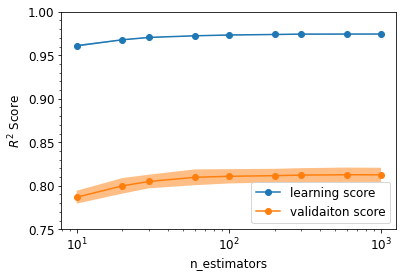

In [75]:
plt.plot(n_estimators_, scores.mean(axis=1)[:, 0], marker="o", label="learning score")
plt.fill_between(n_estimators_,
                 scores.mean(axis=1)[:, 0]-scores.std(axis=1)[:, 0],
                 scores.mean(axis=1)[:, 0]+scores.std(axis=1)[:, 0], alpha=0.5)
plt.plot(n_estimators_, scores.mean(axis=1)[:, 1], marker="o", label="validaiton score")
plt.fill_between(n_estimators_,
                 scores.mean(axis=1)[:, 1]-scores.std(axis=1)[:, 1],
                 scores.mean(axis=1)[:, 1]+scores.std(axis=1)[:, 1], alpha=0.5)
plt.xscale("log")
plt.ylim(0.75 ,1)
plt.xlabel("n_estimators")
plt.ylabel(r"$R^2$ Score")
plt.legend()
plt.show()

In [79]:
max_features_ = list(range(1,9))
scores = []

for max_features in max_features_:
    scores_ = []
    print(f"max_features={max_features}", file=sys.stderr)
    for i,(train_index, test_index) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(df)):
        x_train, x_test = df.values[train_index], df.values[test_index]
        y_train, y_test = housing['target'][train_index], housing['target'][test_index]

        model = RandomForestRegressor(n_estimators=200, max_features=max_features, criterion='mse', n_jobs=-1)
        model.fit(x_train, y_train)
        scores_ += [[model.score(x_train, y_train), model.score(x_test, y_test)]]
    scores += [scores_]
scores = np.array(scores)

max_features=1
max_features=2
max_features=3
max_features=4
max_features=5
max_features=6
max_features=7
max_features=8


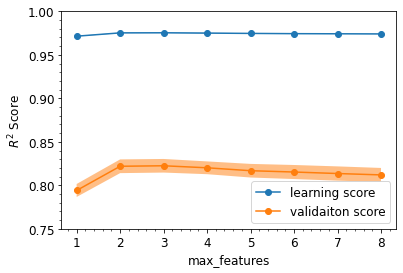

In [81]:
plt.plot(max_features_, scores.mean(axis=1)[:, 0], marker="o", label="learning score")
plt.fill_between(max_features_,
                 scores.mean(axis=1)[:, 0]-scores.std(axis=1)[:, 0],
                 scores.mean(axis=1)[:, 0]+scores.std(axis=1)[:, 0], alpha=0.5)
plt.plot(max_features_, scores.mean(axis=1)[:, 1], marker="o", label="validaiton score")
plt.fill_between(max_features_,
                 scores.mean(axis=1)[:, 1]-scores.std(axis=1)[:, 1],
                 scores.mean(axis=1)[:, 1]+scores.std(axis=1)[:, 1], alpha=0.5)
#plt.xscale("log")
plt.ylim(0.75 ,1)
plt.xlabel("max_features")
plt.ylabel(r"$R^2$ Score")
plt.legend()
plt.show()

In [82]:
model

RandomForestRegressor(max_features=8, n_estimators=200, n_jobs=-1)

In [83]:
model = RandomForestRegressor(max_features=3, n_estimators=200, n_jobs=-1)
model.fit(x_train, y_train)

RandomForestRegressor(max_features=3, n_estimators=200, n_jobs=-1)

In [84]:
model.feature_importances_

array([0.39965804, 0.05538143, 0.0992387 , 0.03884409, 0.03167318,
       0.12841753, 0.12582735, 0.12095967])

In [85]:
from sklearn.linear_model import Lasso

In [124]:
data = np.hstack([df.values, housing['target'][:,None]])
x_train, x_test, y_train, y_test = train_test_split(df, housing['target'],
                                                    test_size=0.2, random_state=42)
scaler = StandardScaler()
scaler.fit(np.hstack([x_train, y_train[:,None]]))
data_train = scaler.transform(np.hstack([x_train, y_train[:,None]]))
data_test = scaler.transform(np.hstack([x_test, y_test[:,None]]))
x_train, x_test, y_train, y_test = data_train[:,:-2], data_test[:,:-2], data_train[:,-1], data_test[:,-1]

(16512, 8)

In [88]:
model = Lasso()
model.fit(x_train, y_train)

Lasso()

In [89]:
model.score(x_train, y_train), model.score(x_test, y_test)

(0.28677899218285774, 0.28231862775746575)

In [106]:
from sklearn.preprocessing import StandardScaler

In [125]:
def objective_lasso(trial):
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1)
    }

    scores = []
    for train_index, test_index in KFold(n_splits=5, shuffle=True, random_state=42).split(df):
        scaler = StandardScaler()
        data = np.hstack([df.values, housing['target'][:,None]])
        scaler.fit(data[train_index])
        xy_train = scaler.transform(data[train_index])
        xy_test = scaler.transform(data[test_index])
        x_train, x_test, y_train, y_test = xy_train[:,:-2], xy_test[:,:-2], xy_train[:,-1], xy_test[:,-1]

        model = Lasso(**params)
        model.fit(x_train, y_train)
        scores += [model.score(x_test, y_test)]
    scores = np.array(scores)
    # スコアの負を返す（目的関数を最小化するため）
    return -scores.mean()

if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective_lasso, n_trials=100)

    print(study.best_params)
    print(study.best_value)
    print(study.best_trial)

[I 2021-07-27 19:56:49,808] A new study created in memory with name: no-name-9d3bf302-aa29-4000-a585-5266273546f1
[I 2021-07-27 19:56:49,890] Trial 0 finished with value: -0.6016572373576079 and parameters: {'alpha': 0.001979434759777127}. Best is trial 0 with value: -0.6016572373576079.
[I 2021-07-27 19:56:49,950] Trial 1 finished with value: -0.46009976721357243 and parameters: {'alpha': 0.14655222325108977}. Best is trial 0 with value: -0.6016572373576079.
[I 2021-07-27 19:56:50,037] Trial 2 finished with value: -0.60138179237603 and parameters: {'alpha': 1.4665128574310139e-05}. Best is trial 0 with value: -0.6016572373576079.
[I 2021-07-27 19:56:50,128] Trial 3 finished with value: -0.6013781892215544 and parameters: {'alpha': 3.479258101283477e-07}. Best is trial 0 with value: -0.6016572373576079.
[I 2021-07-27 19:56:50,181] Trial 4 finished with value: -0.5046802307569487 and parameters: {'alpha': 0.06255018894356652}. Best is trial 0 with value: -0.6016572373576079.
[I 2021-07-

[I 2021-07-27 19:56:53,179] Trial 43 finished with value: -0.6014561661138886 and parameters: {'alpha': 0.004209750741580053}. Best is trial 31 with value: -0.6016603928523827.
[I 2021-07-27 19:56:53,256] Trial 44 finished with value: -0.5878058213902058 and parameters: {'alpha': 0.01890767052689867}. Best is trial 31 with value: -0.6016603928523827.
[I 2021-07-27 19:56:53,351] Trial 45 finished with value: -0.6014451235613345 and parameters: {'alpha': 0.0002843676928532918}. Best is trial 31 with value: -0.6016603928523827.
[I 2021-07-27 19:56:53,429] Trial 46 finished with value: -0.6015992297408637 and parameters: {'alpha': 0.001199964555400936}. Best is trial 31 with value: -0.6016603928523827.
[I 2021-07-27 19:56:53,490] Trial 47 finished with value: -0.504051283204759 and parameters: {'alpha': 0.06413837171496736}. Best is trial 31 with value: -0.6016603928523827.
[I 2021-07-27 19:56:53,565] Trial 48 finished with value: -0.601396720787027 and parameters: {'alpha': 7.507044003122

[I 2021-07-27 19:56:56,567] Trial 87 finished with value: -0.6016537761636783 and parameters: {'alpha': 0.00188556100344146}. Best is trial 51 with value: -0.6016612752331586.
[I 2021-07-27 19:56:56,642] Trial 88 finished with value: -0.5779441002102405 and parameters: {'alpha': 0.0259509891821802}. Best is trial 51 with value: -0.6016612752331586.
[I 2021-07-27 19:56:56,721] Trial 89 finished with value: -0.6014378155444836 and parameters: {'alpha': 0.00025133254370570925}. Best is trial 51 with value: -0.6016612752331586.
[I 2021-07-27 19:56:56,793] Trial 90 finished with value: -0.6000945729221285 and parameters: {'alpha': 0.007524841876545135}. Best is trial 51 with value: -0.6016612752331586.
[I 2021-07-27 19:56:56,873] Trial 91 finished with value: -0.6016612496880857 and parameters: {'alpha': 0.0022997289445679152}. Best is trial 51 with value: -0.6016612752331586.
[I 2021-07-27 19:56:56,951] Trial 92 finished with value: -0.6015959805768605 and parameters: {'alpha': 0.001172681

{'alpha': 0.0022846276346693115}
-0.6016613339956023
FrozenTrial(number=93, values=[-0.6016613339956023], datetime_start=datetime.datetime(2021, 7, 27, 19, 56, 56, 952503), datetime_complete=datetime.datetime(2021, 7, 27, 19, 56, 57, 22896), params={'alpha': 0.0022846276346693115}, distributions={'alpha': LogUniformDistribution(high=1.0, low=1e-08)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=93, state=TrialState.COMPLETE, value=None)


In [127]:
print(model.coef_)

[ 1.45774399e-01  5.92146366e-03  0.00000000e+00 -0.00000000e+00
 -6.85952285e-06 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00]


In [128]:
with open('Lasso_model.bin', mode='wb') as f:
    pickle.dump(model, f)

In [130]:
from sklearn.kernel_ridge import KernelRidge

In [135]:
def objective_kr(trial):
    params = {
        'kernel': 'rbf',
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1)
    }

    scores = []
    for train_index, test_index in KFold(n_splits=3, shuffle=True, random_state=42).split(df):
        scaler = StandardScaler()
        data = np.hstack([df.values, housing['target'][:,None]])
        scaler.fit(data[train_index])
        xy_train = scaler.transform(data[train_index])
        xy_test = scaler.transform(data[test_index])
        x_train, x_test, y_train, y_test = xy_train[:,:-2], xy_test[:,:-2], xy_train[:,-1], xy_test[:,-1]

        model = KernelRidge(**params)
        model.fit(x_train, y_train)
        scores += [model.score(x_test, y_test)]
    scores = np.array(scores)
    # スコアの負を返す（目的関数を最小化するため）
    return -scores.mean()

if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective_kr, n_trials=20)

    print(study.best_params)
    print(study.best_value)
    print(study.best_trial)

[I 2021-07-27 20:21:35,471] A new study created in memory with name: no-name-08f9996a-ecbd-4820-be2c-ec51f2426ecd
[I 2021-07-27 20:22:13,644] Trial 0 finished with value: 98.70160290513586 and parameters: {'alpha': 3.561709293376304e-08, 'gamma': 0.08516990928971344}. Best is trial 0 with value: 98.70160290513586.
[I 2021-07-27 20:22:51,425] Trial 1 finished with value: -0.0010472614174746875 and parameters: {'alpha': 0.3553548289843493, 'gamma': 1.3935614277285742e-08}. Best is trial 1 with value: -0.0010472614174746875.
[I 2021-07-27 20:23:31,411] Trial 2 finished with value: -0.774072028813286 and parameters: {'alpha': 0.2891466958322625, 'gamma': 0.51893875086944}. Best is trial 2 with value: -0.774072028813286.
[I 2021-07-27 20:24:10,828] Trial 3 finished with value: -0.5350086571239797 and parameters: {'alpha': 0.0004534762746803521, 'gamma': 0.0003052246532011858}. Best is trial 2 with value: -0.774072028813286.
[I 2021-07-27 20:24:49,322] Trial 4 finished with value: 37.6001143

{'alpha': 0.09263366274829903, 'gamma': 0.3023471641046272}
-0.7760854935529471
FrozenTrial(number=18, values=[-0.7760854935529471], datetime_start=datetime.datetime(2021, 7, 27, 20, 33, 35, 864620), datetime_complete=datetime.datetime(2021, 7, 27, 20, 34, 15, 841972), params={'alpha': 0.09263366274829903, 'gamma': 0.3023471641046272}, distributions={'alpha': LogUniformDistribution(high=1.0, low=1e-08), 'gamma': LogUniformDistribution(high=1.0, low=1e-08)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=18, state=TrialState.COMPLETE, value=None)


In [136]:
if __name__ == '__main__':
    #study = optuna.create_study()
    study.optimize(objective_kr, n_trials=20)

    print(study.best_params)
    print(study.best_value)
    print(study.best_trial)

[I 2021-07-27 20:37:26,617] Trial 20 finished with value: -0.5955234459968664 and parameters: {'alpha': 0.003484197530293403, 'gamma': 5.4870808908371826e-05}. Best is trial 18 with value: -0.7760854935529471.
[I 2021-07-27 20:38:05,352] Trial 21 finished with value: -0.7764715034344759 and parameters: {'alpha': 0.07759761448035783, 'gamma': 0.35620427426081175}. Best is trial 21 with value: -0.7764715034344759.
[I 2021-07-27 20:38:44,394] Trial 22 finished with value: -0.767285050152758 and parameters: {'alpha': 0.12176232511325516, 'gamma': 0.9938276030759435}. Best is trial 21 with value: -0.7764715034344759.
[I 2021-07-27 20:39:23,083] Trial 23 finished with value: -0.7121447001050539 and parameters: {'alpha': 0.9387504736295331, 'gamma': 0.03772069954226896}. Best is trial 21 with value: -0.7764715034344759.
[I 2021-07-27 20:40:01,759] Trial 24 finished with value: -0.7752760998943877 and parameters: {'alpha': 0.04994285037723684, 'gamma': 0.23633550769224546}. Best is trial 21 wi

{'alpha': 0.07759761448035783, 'gamma': 0.35620427426081175}
-0.7764715034344759
FrozenTrial(number=21, values=[-0.7764715034344759], datetime_start=datetime.datetime(2021, 7, 27, 20, 37, 26, 618897), datetime_complete=datetime.datetime(2021, 7, 27, 20, 38, 5, 350096), params={'alpha': 0.07759761448035783, 'gamma': 0.35620427426081175}, distributions={'alpha': LogUniformDistribution(high=1.0, low=1e-08), 'gamma': LogUniformDistribution(high=1.0, low=1e-08)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=21, state=TrialState.COMPLETE, value=None)


In [138]:
n_samples = [int(df.index.size*0.8*min(0.001 * 1.4**i,1)) for i in range(22)]
scores = []

for n_sample in n_samples:
    scores_ = []
    print(f"n_sample={n_sample}", file=sys.stderr)
    for i,(train_index, test_index) in enumerate(KFold(n_splits=3, shuffle=True, random_state=42).split(df)):
        scaler = StandardScaler()
        data = np.hstack([df.values, housing['target'][:,None]])
        scaler.fit(data[train_index])
        xy_train = scaler.transform(data[train_index[:n_sample]])
        xy_test = scaler.transform(data[test_index])
        x_train, x_test, y_train, y_test = xy_train[:,:-2], xy_test[:,:-2], xy_train[:,-1], xy_test[:,-1]

        model = KernelRidge(**study.best_params)
        model.fit(x_train, y_train)
        scores_ += [[model.score(x_train, y_train), model.score(x_test, y_test)]]
    scores += [scores_]
scores = np.array(scores)

n_sample=16
n_sample=23
n_sample=32
n_sample=45
n_sample=63
n_sample=88
n_sample=124
n_sample=174
n_sample=243
n_sample=341
n_sample=477
n_sample=668
n_sample=936
n_sample=1310
n_sample=1834
n_sample=2568
n_sample=3596
n_sample=5034
n_sample=7048
n_sample=9868
n_sample=13815
n_sample=16512


In [144]:
np.save('KR_learning.npy', scores)

In [188]:
scores=np.load('KR_learning.npy')

In [191]:
[int(df.index.size*0.8*min(0.001 * 1.4**i,1)) for i in range(22)]

[16,
 23,
 32,
 45,
 63,
 88,
 124,
 174,
 243,
 341,
 477,
 668,
 936,
 1310,
 1834,
 2568,
 3596,
 5034,
 7048,
 9868,
 13815,
 16512]

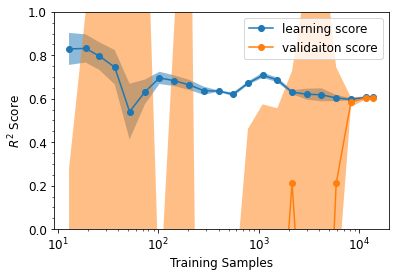

In [189]:
n_samples = [int(df.index.size*2/3*min(0.001 * 1.4**i,1)) for i in range(22)]
plt.plot(n_samples, scores.mean(axis=1)[:, 0], marker="o", label="learning score")
plt.fill_between(n_samples,
                 scores.mean(axis=1)[:, 0]-scores.std(axis=1)[:, 0],
                 scores.mean(axis=1)[:, 0]+scores.std(axis=1)[:, 0], alpha=0.5)
plt.plot(n_samples, scores.mean(axis=1)[:, 1], marker="o", label="validaiton score")
plt.fill_between(n_samples,
                 scores.mean(axis=1)[:, 1]-scores.std(axis=1)[:, 1],
                 scores.mean(axis=1)[:, 1]+scores.std(axis=1)[:, 1], alpha=0.5)
plt.xscale("log")
plt.ylim(0,1)
plt.legend()
plt.xlabel("Training Samples")
plt.ylabel(r"$R^2$ Score")
plt.show()

In [157]:
alphas = [1e-4 * 2**i for i in range(14)]
scores = []

for alpha in alphas:
    scores_ = []
    print(f"alpha={alpha}", file=sys.stderr, end='')
    for i,(train_index, test_index) in enumerate(KFold(n_splits=3, shuffle=True, random_state=42).split(df)):
        scaler = StandardScaler()
        data = np.hstack([df.values, housing['target'][:,None]])
        scaler.fit(data[train_index])
        xy_train = scaler.transform(data[train_index])
        xy_test = scaler.transform(data[test_index])
        x_train, x_test, y_train, y_test = xy_train[:,:-2], xy_test[:,:-2], xy_train[:,-1], xy_test[:,-1]

        model = KernelRidge(kernel='rbf', alpha=alpha, gamma=study.best_params['gamma'])
        model.fit(x_train, y_train)
        scores_ += [[model.score(x_train, y_train), model.score(x_test, y_test)]]
        print(f"; {scores_[-1][0]}, {scores_[-1][1]}", file=sys.stderr, end='')
    print('', file=sys.stderr)
    scores += [scores_]
scores = np.array(scores)

alpha=0.0001; 0.9148744094616154, 0.43025858147863283; 0.9161614244712287, 0.4180540309501851; 0.9168610413479821, 0.4079063778785502
alpha=0.0002; 0.906659436461228, 0.5676368010204664; 0.9081696160983902, 0.5653209171929167; 0.9087622963946981, 0.5303050393234945
alpha=0.0004; 0.8982637466021286, 0.6489860686866324; 0.9001442823638968, 0.6445977241825118; 0.9004550579480829, 0.6008475456201279
alpha=0.0008; 0.8897286781729525, 0.6971445272642851; 0.8921232325759857, 0.6892509355004399; 0.8920277257449483, 0.6500177488571568
alpha=0.0016; 0.8810637807898265, 0.7263809317048024; 0.8840524962596236, 0.7183963391915763; 0.8834900022112787, 0.6897464546678937
alpha=0.0032; 0.8722344223247083, 0.7447790134648822; 0.8758173918571566, 0.7399906447934754; 0.8747701087048831, 0.7222435121611446
alpha=0.0064; 0.8632175551368233, 0.7567219890058409; 0.8673413244146716, 0.7563554343828458; 0.8657558561569798, 0.7466111856381659
alpha=0.0128; 0.854020816917143, 0.764551137337589; 0.858603202201556

In [158]:
np.save('KR_validation_alpha.npy', scores)

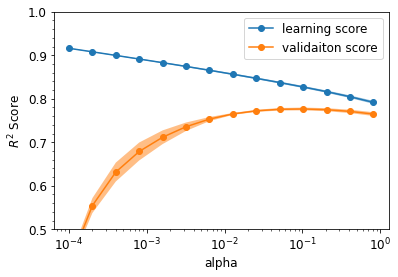

In [162]:
plt.plot(alphas, scores.mean(axis=1)[:, 0], marker="o", label="learning score")
plt.fill_between(alphas,
                 scores.mean(axis=1)[:, 0]-scores.std(axis=1)[:, 0],
                 scores.mean(axis=1)[:, 0]+scores.std(axis=1)[:, 0], alpha=0.5)
plt.plot(alphas, scores.mean(axis=1)[:, 1], marker="o", label="validaiton score")
plt.fill_between(alphas,
                 scores.mean(axis=1)[:, 1]-scores.std(axis=1)[:, 1],
                 scores.mean(axis=1)[:, 1]+scores.std(axis=1)[:, 1], alpha=0.5)
plt.xscale("log")
plt.ylim(0.5 ,1)
plt.xlabel("alpha")
plt.ylabel(r"$R^2$ Score")
plt.legend()
plt.show()

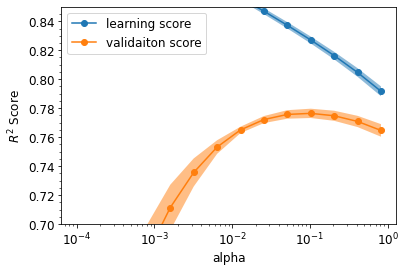

In [163]:
plt.plot(alphas, scores.mean(axis=1)[:, 0], marker="o", label="learning score")
plt.fill_between(alphas,
                 scores.mean(axis=1)[:, 0]-scores.std(axis=1)[:, 0],
                 scores.mean(axis=1)[:, 0]+scores.std(axis=1)[:, 0], alpha=0.5)
plt.plot(alphas, scores.mean(axis=1)[:, 1], marker="o", label="validaiton score")
plt.fill_between(alphas,
                 scores.mean(axis=1)[:, 1]-scores.std(axis=1)[:, 1],
                 scores.mean(axis=1)[:, 1]+scores.std(axis=1)[:, 1], alpha=0.5)
plt.xscale("log")
plt.ylim(0.7 ,0.85)
plt.xlabel("alpha")
plt.ylabel(r"$R^2$ Score")
plt.legend()
plt.show()

In [168]:
gammas = [1e-3 * 2**i for i in range(14)]
scores = []

for gamma in gammas:
    scores_ = []
    print(f"gamma={gamma}", file=sys.stderr, end='')
    for i,(train_index, test_index) in enumerate(KFold(n_splits=3, shuffle=True, random_state=42).split(df)):
        scaler = StandardScaler()
        data = np.hstack([df.values, housing['target'][:,None]])
        scaler.fit(data[train_index])
        xy_train = scaler.transform(data[train_index])
        xy_test = scaler.transform(data[test_index])
        x_train, x_test, y_train, y_test = xy_train[:,:-2], xy_test[:,:-2], xy_train[:,-1], xy_test[:,-1]

        model = KernelRidge(kernel='rbf', gamma=gamma, alpha=study.best_params['alpha'])
        model.fit(x_train, y_train)
        scores_ += [[model.score(x_train, y_train), model.score(x_test, y_test)]]
        print(f"; {scores_[-1][0]:.4f}, {scores_[-1][1]:.4f}", file=sys.stderr, end='')
    print('', file=sys.stderr)
    scores += [scores_]
scores = np.array(scores)
np.save('KR_validation_gamma.npy', scores)

gamma=0.001; 0.6440, 0.6323; 0.6454, 0.6498; 0.6421, 0.6329
gamma=0.002; 0.6607, 0.6443; 0.6625, 0.6595; 0.6577, 0.6550
gamma=0.004; 0.6798, 0.6643; 0.6846, 0.6825; 0.6807, 0.6760
gamma=0.008; 0.7005, 0.6923; 0.7074, 0.7011; 0.7040, 0.6976
gamma=0.016; 0.7188, 0.7091; 0.7261, 0.7207; 0.7216, 0.7126
gamma=0.032; 0.7399, 0.7254; 0.7471, 0.7394; 0.7427, 0.7304
gamma=0.064; 0.7635, 0.7447; 0.7681, 0.7561; 0.7654, 0.7485
gamma=0.128; 0.7893, 0.7637; 0.7938, 0.7722; 0.7905, 0.7663
gamma=0.256; 0.8151, 0.7722; 0.8204, 0.7793; 0.8163, 0.7749
gamma=0.512; 0.8459, 0.7706; 0.8514, 0.7790; 0.8479, 0.7755
gamma=1.024; 0.8854, 0.7597; 0.8900, 0.7694; 0.8887, 0.7623
gamma=2.048; 0.9311, 0.7303; 0.9351, 0.7358; 0.9340, 0.7263
gamma=4.096; 0.9696, 0.6680; 0.9718, 0.6722; 0.9707, 0.6575
gamma=8.192; 0.9896, 0.5469; 0.9905, 0.5585; 0.9897, 0.5362


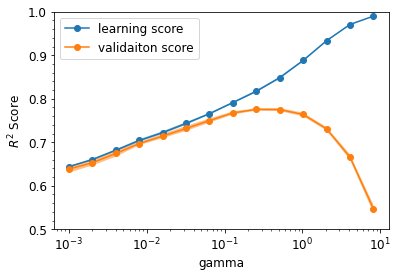

In [169]:
plt.plot(gammas, scores.mean(axis=1)[:, 0], marker="o", label="learning score")
plt.fill_between(gammas,
                 scores.mean(axis=1)[:, 0]-scores.std(axis=1)[:, 0],
                 scores.mean(axis=1)[:, 0]+scores.std(axis=1)[:, 0], alpha=0.5)
plt.plot(gammas, scores.mean(axis=1)[:, 1], marker="o", label="validaiton score")
plt.fill_between(gammas,
                 scores.mean(axis=1)[:, 1]-scores.std(axis=1)[:, 1],
                 scores.mean(axis=1)[:, 1]+scores.std(axis=1)[:, 1], alpha=0.5)
plt.xscale("log")
plt.ylim(0.5 ,1)
plt.xlabel("gamma")
plt.ylabel(r"$R^2$ Score")
plt.legend()
plt.show()

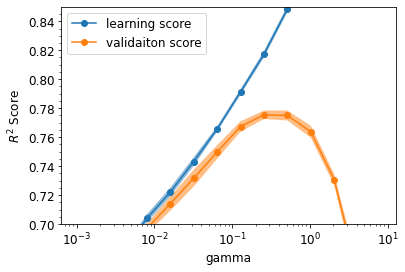

In [170]:
plt.plot(gammas, scores.mean(axis=1)[:, 0], marker="o", label="learning score")
plt.fill_between(gammas,
                 scores.mean(axis=1)[:, 0]-scores.std(axis=1)[:, 0],
                 scores.mean(axis=1)[:, 0]+scores.std(axis=1)[:, 0], alpha=0.5)
plt.plot(gammas, scores.mean(axis=1)[:, 1], marker="o", label="validaiton score")
plt.fill_between(gammas,
                 scores.mean(axis=1)[:, 1]-scores.std(axis=1)[:, 1],
                 scores.mean(axis=1)[:, 1]+scores.std(axis=1)[:, 1], alpha=0.5)
plt.xscale("log")
plt.ylim(0.7 ,0.85)
plt.xlabel("gamma")
plt.ylabel(r"$R^2$ Score")
plt.legend()
plt.show()

In [171]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [176]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
scaler = StandardScaler()
data = np.hstack([df.values, housing['target'][:,None]])

ab = pca.fit_transform(data)

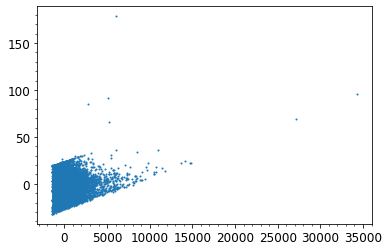

In [178]:
plt.scatter(ab[:,0], ab[:,1], s=1)

In [179]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(data)
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

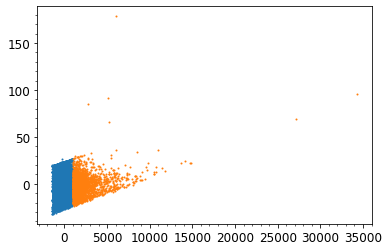

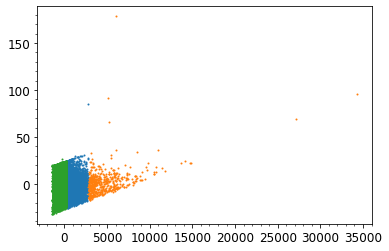

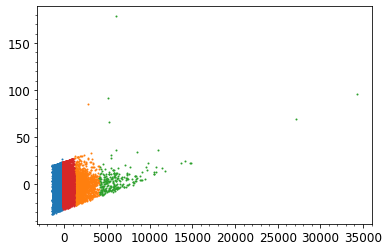

In [185]:
for k in range(2,5):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
    for i in range(k):
        plt.scatter(ab[:,0][kmeans.labels_==i], ab[:,1][kmeans.labels_==i], s=1)
    #plt.xlim(-2000, 2000)
    #plt.ylim(-50,50)
    plt.show()

In [193]:
test_x

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
20046,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01
3024,2.5313,30.0,5.039384,1.193493,1565.0,2.679795,35.14,-119.46
15663,3.4801,52.0,3.977155,1.185877,1310.0,1.360332,37.80,-122.44
20484,5.7376,17.0,6.163636,1.020202,1705.0,3.444444,34.28,-118.72
9814,3.7250,34.0,5.492991,1.028037,1063.0,2.483645,36.62,-121.93
...,...,...,...,...,...,...,...,...
15362,4.6050,16.0,7.002212,1.066372,1351.0,2.988938,33.36,-117.22
16623,2.7266,28.0,6.131915,1.256738,1650.0,2.340426,35.36,-120.83
18086,9.2298,25.0,7.237676,0.947183,1585.0,2.790493,37.31,-122.05
2144,2.7850,36.0,5.289030,0.983122,1227.0,2.588608,36.77,-119.76


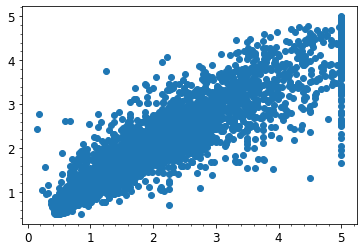

In [194]:
model = RandomForestRegressor(n_estimators=200, max_features=2)
model.fit(train_x, train_y)
test_p = model.predict(test_x)
plt.scatter(test_y, test_p)

Text(0, 0.5, 'predicted')

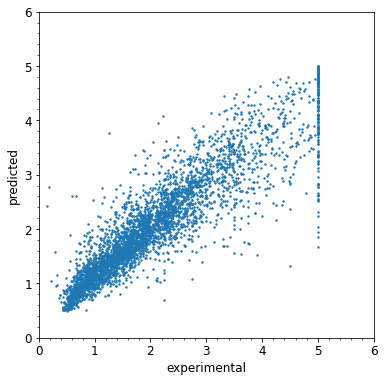

In [197]:
plt.figure(figsize=(6,6))
plt.scatter(test_y, test_p, s=2)
plt.ylim(0,6)
plt.xlim(0,6)
plt.xlabel("experimental")
plt.ylabel("predicted")

In [198]:
study.best_params

{'alpha': 0.07759761448035783, 'gamma': 0.35620427426081175}

In [202]:
scaler = StandardScaler()
data = np.hstack([train_x, train_y[:,None]])
scaler.fit(data)
xy_train = scaler.transform(data)
xy_test = scaler.transform(np.hstack([test_x, test_y[:,None]]))
x_train, x_test, y_train, y_test = xy_train[:,:-2], xy_test[:,:-2], xy_train[:,-1], xy_test[:,-1]

model = KernelRidge(kernel='rbf', **study.best_params)
model.fit(x_train, y_train)
p_test = model.predict(x_test)

Text(0, 0.5, 'predicted')

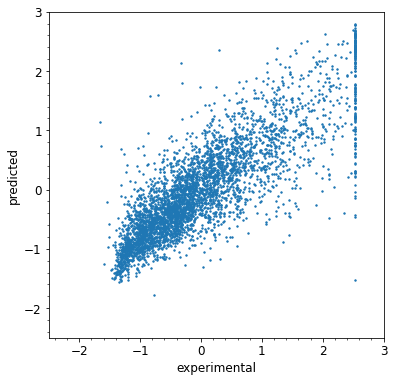

In [207]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, p_test, s=2)
plt.ylim(-2.5,3)
plt.xlim(-2.5,3)
plt.xlabel("experimental")
plt.ylabel("predicted")